# Testing notebook for nifty fit on atmosphere TODs directly (no image)

# Try to add a nifty model for sampling the input map

numpy version: 2.1.1


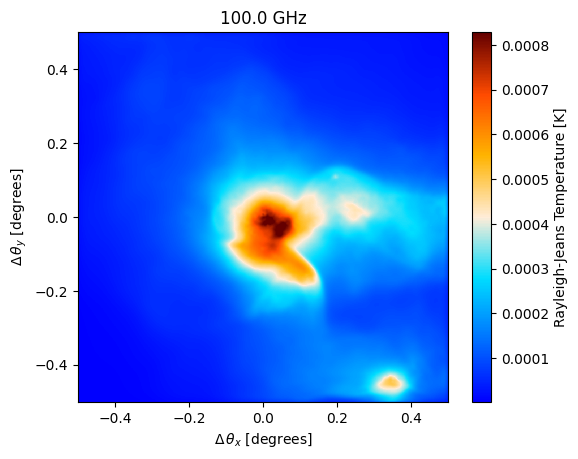

In [1]:
import numpy as np
print(f"numpy version: {np.__version__}")
import matplotlib.pyplot as plt
import maria
import sys
import os

# Relative import of sample_maps for now
sys.path.append(os.path.abspath('../python'))
import mapsampling_jax
from mapsampling_jax import sample_maps

map_filename = maria.io.fetch("maps/big_cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename,
                                width=1., #degrees
                                index=1,
                                center=(300.0, -10.0), #RA and Dec in degrees
                                units ='Jy/pixel'
                               )

input_map.to(units="K_RJ").plot()

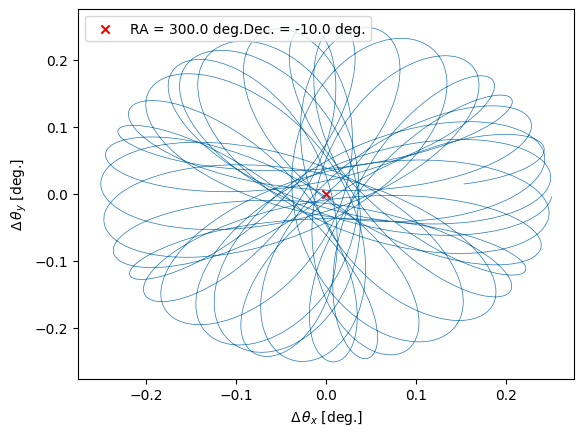

In [2]:
plan = maria.get_plan(scan_pattern="daisy",
                      scan_options={"radius": 0.25, "speed": 0.5}, # in degrees
                      duration=60, # in seconds
                      sample_rate=225, # in Hz
                        # sample_rate=20, # in Hz
                      start_time = "2022-08-10T06:00:00",
                      scan_center=(300.0, -10.0),
                      frame="ra_dec")
plan.plot()

2024-10-11 16:45:00.695 INFO: Initialized base in 16522 ms.
Building atmosphere: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
2024-10-11 16:45:06.476 INFO: Initialized atmosphere in 5750 ms.
Generating noise: 100%|██████████| 1/1 [00:09<00:00,  9.05s/it]


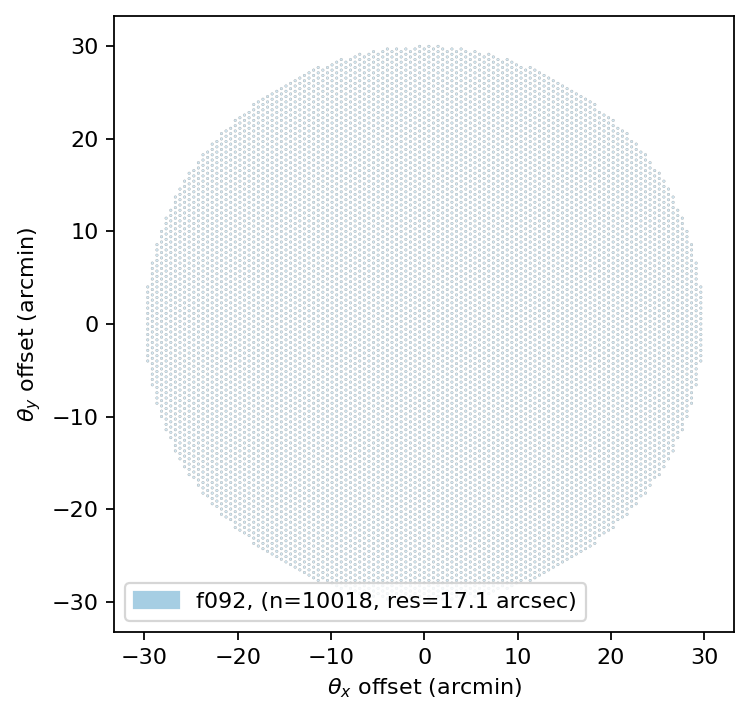

In [3]:
# instrument = maria.get_instrument('MUSTANG-2')
instrument = mapsampling_jax.get_atlast()
instrument.plot()

sim_truthmap = maria.Simulation(instrument, 
                                plan=plan,
                                site="llano_de_chajnantor", 
                                map=input_map,
                                # noise=False,
                                atmosphere="2d",
                                # cmb="generate",
                                )

tod_truthmap = sim_truthmap.run()

In [4]:
dx, dy = sim_truthmap.coords.offsets(frame=sim_truthmap.map.frame, center=sim_truthmap.map.center)
dx = dx.compute()
dy = dy.compute()

dx

array([[0.00268379, 0.00271391, 0.00274352, ..., 0.00437843, 0.00438132,
        0.00438451],
       [0.00281811, 0.00284823, 0.00287784, ..., 0.00451267, 0.00451555,
        0.00451875],
       [0.00254947, 0.00257959, 0.00260919, ..., 0.0042442 , 0.00424708,
        0.00425027],
       ...,
       [0.00316096, 0.00319091, 0.00322035, ..., 0.004863  , 0.00486572,
        0.00486876],
       [0.00948224, 0.00951246, 0.00954217, ..., 0.01117219, 0.01117517,
        0.01117846],
       [0.01081717, 0.01084723, 0.01087678, ..., 0.01251451, 0.01251733,
        0.01252047]])

Running mapper (f092): 100%|██████████| 1/1 [00:45<00:00, 45.40s/it]


mapdata_truth shape: (1, 1024, 1024)
mapdata_truth mean: 0.00013284593853240577


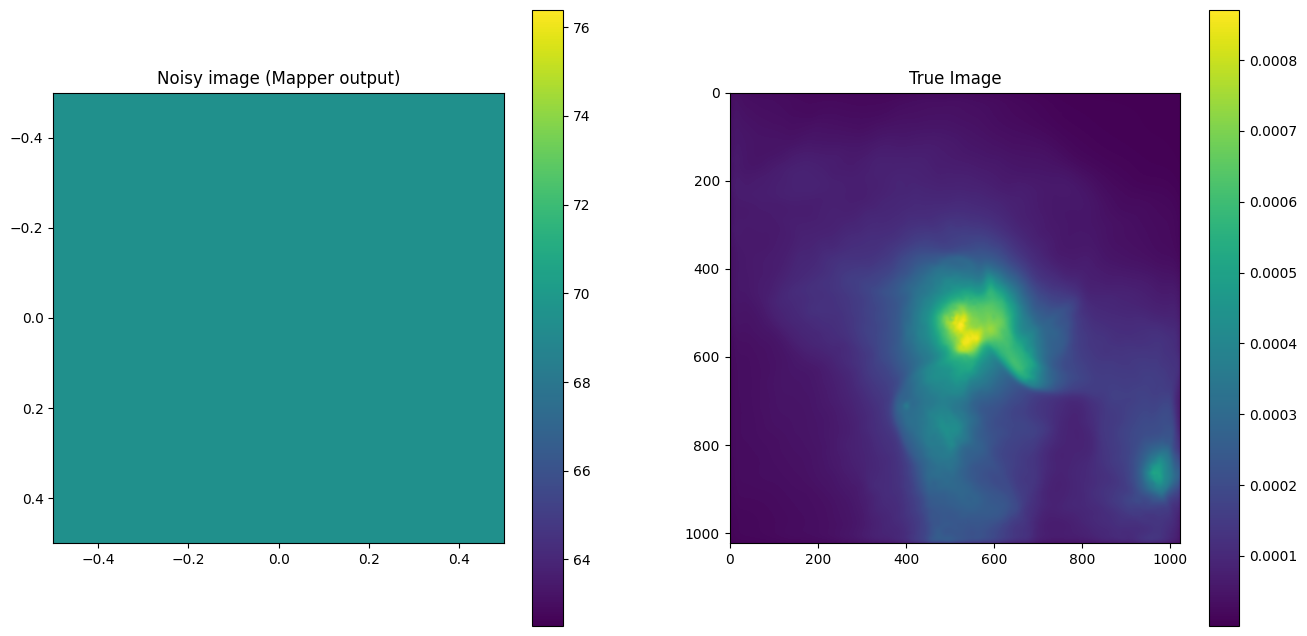

In [5]:
from maria.map.mappers import BinMapper

# Run mapper without any filtering to get noisy mimge
# mapper_truthmap = BinMapper(center=(150, 10), frame="ra_dec", width=0.1, height=0.1, resolution=2e-4, map_postprocessing={"gaussian_filter": {"sigma": 0}} )
# mapper_truthmap = BinMapper(center=(300.0, -10.0), frame="ra_dec", width=1., height=1., resolution=np.degrees(np.nanmin(instrument.fwhm))/4., map_postprocessing={"gaussian_filter": {"sigma": 0} } )
mapper_truthmap = BinMapper(center=(300.0, -10.0), frame="ra_dec", width=1., height=1., resolution=np.rad2deg(instrument.dets.fwhm[0]) * 3600, map_postprocessing={"gaussian_filter": {"sigma": 0} } )
mapper_truthmap.add_tods(tod_truthmap)
output_truthmap = mapper_truthmap.run()

mapdata_truth = np.float64(sim_truthmap.map.data)
mapdata_truth = np.nan_to_num(mapdata_truth, nan=np.nanmean(mapdata_truth)) # replace nan value by img mean

print("mapdata_truth shape:", mapdata_truth.shape)
print("mapdata_truth mean:", mapdata_truth.mean())

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(output_truthmap.data[0].T)
fig.colorbar(im0)
axes[0].title.set_text("Noisy image (Mapper output)")

im1 = axes[1].imshow(mapdata_truth[0])
fig.colorbar(im1)
axes[1].title.set_text("True Image")

plt.show()

# Re-implement map sampling in JAX for nifty response function:

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import jax
from jax import random
import jax.numpy as jnp

import nifty8.re as jft
import matplotlib.pyplot as plt

import numpy as np

from functools import reduce
from operator import or_

seed = 42
key = random.PRNGKey(seed)

2024-10-11 16:47:13.962 INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-10-11 16:47:13.964 INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


# Test TOD agreement:

In [9]:
# sim_truthmap_x_side = jax.numpy.flip(sim_truthmap.map.x_side)
# sim_truthmap_y_side = jax.numpy.flip(sim_truthmap.map.y_side)
sim_truthmap_x_side = sim_truthmap.map.x_side
sim_truthmap_y_side = sim_truthmap.map.y_side

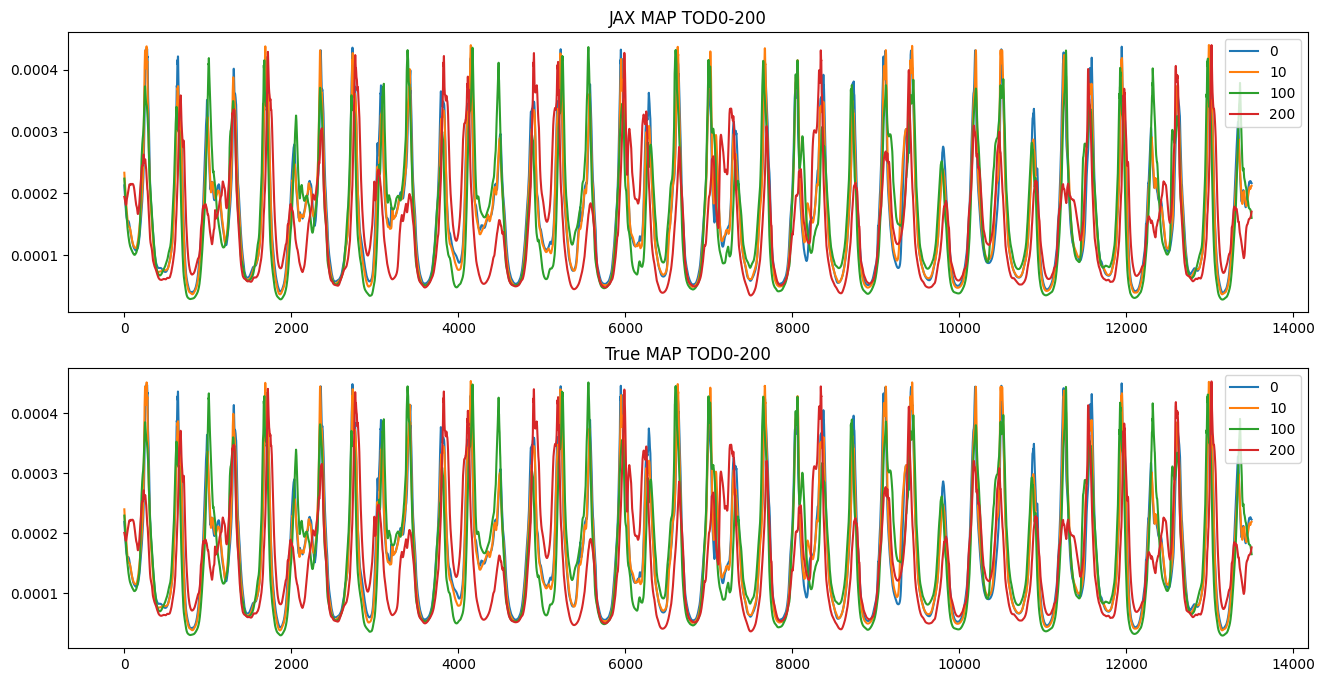

In [10]:
jax_tods_map = sample_maps(mapdata_truth, dx, dy, sim_truthmap.map.resolution, sim_truthmap_x_side, sim_truthmap_y_side)

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(jax_tods_map[i], label=i)

    tods_map = np.float64(tod_truthmap.get_field('map').compute())
    im1 = axes[1].plot(tods_map[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'True MAP TOD0-{i}')
axes[1].legend()

plt.show()

# Prepare noised input TODs:

Noise stddev: 0.0002809539615324277


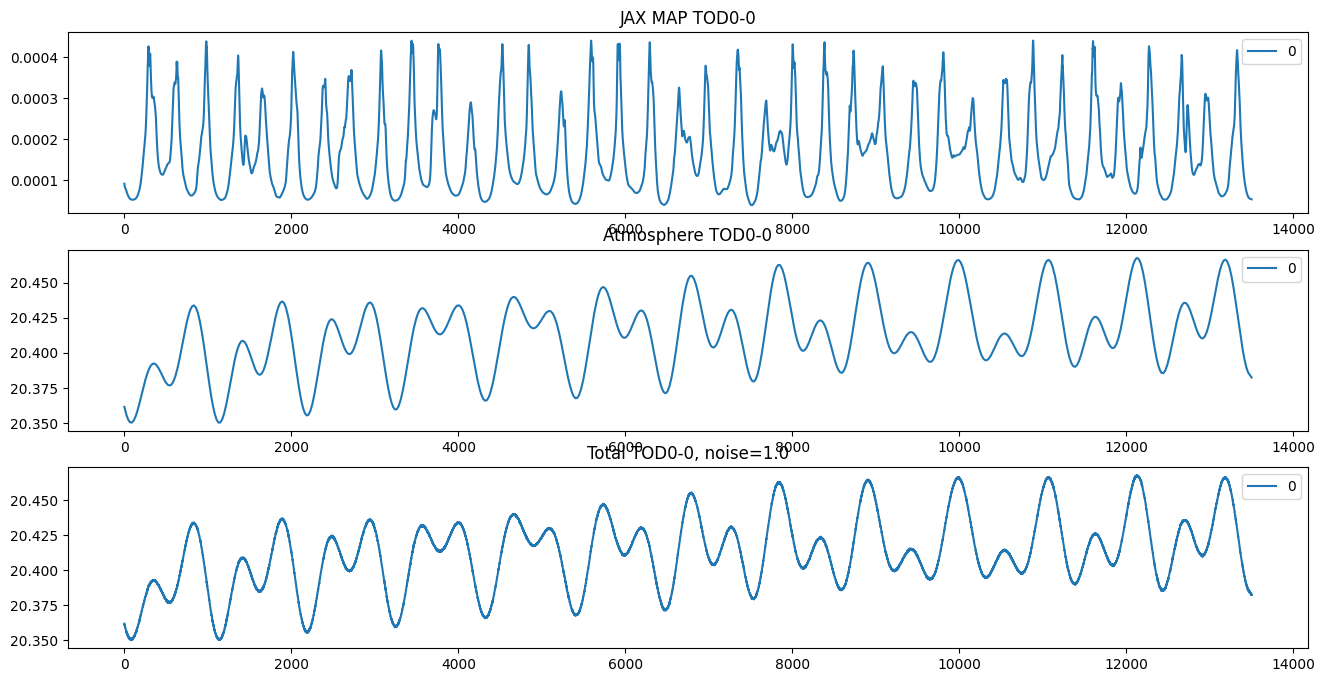

In [25]:
# Pick noise level for rest of run:
# noiselevel = 0.0
# noiselevel = 0.1
# noiselevel = 0.5
noiselevel = 1.0

# Add n TODs for atmos:
# n = 1
n = 100
# n = jax_tods_map.shape[0]

jax_tods_atmos = tod_truthmap.get_field('atmosphere')
# noised_jax_tod = np.float64(jax_tods_map) + np.float64(jax_tods_atmos) + np.float64(tod_truthmap.components['noise']*noiselevel)

noised_jax_tod = np.float64(jax_tods_map) + np.float64(tod_truthmap.get_field('noise')*noiselevel)
noised_jax_tod[:n] += np.float64(jax_tods_atmos[:n]) 
# noised_jax_tod[:n] = np.float64(jax_tods_atmos[:n])

denoised_jax_tod = noised_jax_tod - np.float64(tod_truthmap.get_field('noise')*noiselevel)

print("Noise stddev:", np.std(tod_truthmap.get_field('noise').compute()))

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

for i in [0]:
# for i in range(0, n, n//10):
    im0 = axes[0].plot(jax_tods_map[i], label=i)
    im1 = axes[1].plot(jax_tods_atmos[i], label=i)
    # im1 = axes[1].plot(jax_tods_atmos_smooth[i], label=i)
    im2 = axes[2].plot(noised_jax_tod[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'Atmosphere TOD0-{i}')
axes[1].legend()
axes[2].title.set_text(f'Total TOD0-{i}, noise={noiselevel}')
axes[2].legend()

plt.show()

# Next, initialise nifty prior model

Start with the atmosphere TOD model:

In [26]:
dims_atmos = (jax_tods_atmos.shape[1] + 2000,)
padding_atmos = dims_atmos[0] - jax_tods_atmos.shape[1]

# correlated field zero mode GP offset and stddev
# cf_zm_tod = dict(offset_mean=jax_tods_atmos.mean().compute(), offset_std=(0.001, 0.1))
cf_zm_tod = dict(offset_mean=jax_tods_atmos.mean().compute(), offset_std=(0.0005, 0.001))

# correlated field fluctuations (mostly don't need tuning)
# fluctuations: y-offset in power spectrum in fourier space (zero mode)
# loglogavgslope: power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
# flexibility=(1.5e0, 5e-1), # deviation from simple power-law
# asperity=(5e-1, 5e-2), # small scale features in power-law
cf_fl_tod = dict(
    # fluctuations=(0.005, 0.005), 
    fluctuations=(0.005, 0.003), 
    loglogavgslope=(-3, 0.5), 
    flexibility=None,
    asperity=None,
)

# put together in correlated field model
cfm_tod = jft.CorrelatedFieldMaker("")
cfm_tod.set_amplitude_total_offset(**cf_zm_tod)
cfm_tod.add_fluctuations(
    dims_atmos, distances=1.0 / dims_atmos[0], **cf_fl_tod, prefix="tod ", non_parametric_kind="power"
)
# gp_tod = cfm_tod.finalize()

## Add one Correlated field per TOD with shared flucts and zero-mean

In [27]:
# init params for each TOD:

gps_tods = []
for i in range(n):
    cfmi = jft.CorrelatedFieldMaker(f'tod{i} ')
    # cfmi.set_amplitude_total_offset(**cf_zm_tod)
    cfmi._azm = cfm_tod._azm
    cfmi._offset_mean = cfm_tod._offset_mean
    cfmi._parameter_tree['zeromode'] = jft.ShapeWithDtype(())

    cfmi._fluctuations.append(cfm_tod._fluctuations[0])
    cfmi._target_grids.append(cfm_tod._target_grids[0])
    cfmi._parameter_tree.update(cfm_tod._fluctuations[0].domain)
    gps_tods.append(cfmi.finalize())

## Now for the map model:

In [28]:
mapdata_truth.shape[1]

1024

In [29]:
dims_map = (mapdata_truth.shape[1] + 200, mapdata_truth.shape[2] + 200)
padding_map = dims_map[0] - mapdata_truth.shape[1]

# Map model

# correlated field zero mode GP offset and stddev
# cf_zm_map = dict(offset_mean=mapdata_truth.mean(), offset_std=(1e-7, 1e-6))
cf_zm_map = dict(offset_mean=mapdata_truth.mean(), offset_std=(1e-8, 1e-7))
# correlated field fluctuations (mostly don't need tuning)
cf_fl_map = dict(
    # fluctuations=(2e-6, 1e-6), # fluctuations: y-offset in power spectrum in fourier space (zero mode)
    fluctuations=(3e-5, 1e-5), # fluctuations: y-offset in power spectrum in fourier space (zero mode)
    loglogavgslope=(-2.5e0, 5e-1), # power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
    flexibility=None,
    asperity=None,
    # flexibility=(1.5e0, 5e-1), # deviation from simple power-law
    # asperity=(5e-1, 5e-2), # small scale features in power-law
)

# put together in correlated field model
cfm_map = jft.CorrelatedFieldMaker("cfmap")
cfm_map.set_amplitude_total_offset(**cf_zm_map)
cfm_map.add_fluctuations(
    dims_map, distances=1.0 / dims_map[0], **cf_fl_map, prefix="ax1", non_parametric_kind="power"
)
gp_map = cfm_map.finalize()

In [30]:
# only tod:
# class Signal_TOD(jft.Model):
#     def __init__(self, gps_tods):
#         # self.gp_tod = gp_tod
#         # super().__init__(init=self.gp_tod.init, domain=jft.Vector(gp_tod.domain))
#         self.gps_tods = gps_tods
#         self.tgt = (len(gps_tods), gps_tods[0].target.size)
#         # self.gp_map = gp_map
#         # super().__init__(init=reduce(or_, [gp.init for gp in gps_tods] + [gp_map.init]), domain=reduce(or_, [gp.domain for gp in gps_tods] + [gp_map.domain]))
#         super().__init__(init=reduce(or_, [gp.init for gp in gps_tods]), domain=reduce(or_, [gp.domain for gp in gps_tods]))
    
#     def __call__(self, x):
#         res_tods = jnp.zeros(self.tgt)
#         for i, gp in enumerate(self.gps_tods):
#             res_tods = res_tods.at[i].set(gp(x))
        
#         return res_tods[:, padding_atmos//2:-padding_atmos//2]

#         # res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims_map[0], dims_map[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap_x_side, sim_truthmap_y_side)

#         # # Only add first n atmosphere tods, otherwise use map
#         # modified_res_map = res_map.at[:n, :].add(res_tods[:, padding_atmos//2:-padding_atmos//2])

#         # return modified_res_map

# signal_response_tod = Signal_TOD(gps_tods)

# map only:
# class Signal_TOD(jft.Model):
#     def __init__(self, gp_map):
#         # self.gp_tod = gp_tod
#         # super().__init__(init=self.gp_tod.init, domain=jft.Vector(gp_tod.domain))
#         # self.gps_tods = gps_tods
#         # self.tgt = (len(gps_tods), gps_tods[0].target.size)
#         self.gp_map = gp_map
#         # super().__init__(init=reduce(or_, [gp.init for gp in gps_tods] + [gp_map.init]), domain=reduce(or_, [gp.domain for gp in gps_tods] + [gp_map.domain]))
#         super().__init__(init=gp_map.init, domain=gp_map.domain)
    
#     def __call__(self, x):
#         # res_tods = jnp.zeros(self.tgt)
#         # for i, gp in enumerate(self.gps_tods):
#         #     res_tods = res_tods.at[i].set(gp(x))
        
#         # res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims_map[0], dims_map[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap_x_side, sim_truthmap_y_side)
#         res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims_map[0], dims_map[1]))[:, padding_map//2:-padding_map//2, padding_map//2:-padding_map//2], dx, dy, sim_truthmap.map.resolution, sim_truthmap_x_side, sim_truthmap_y_side)
#         return res_map

#         # Only add first n atmosphere tods, otherwise use map
#         # modified_res_map = res_map.at[:n, :].add(res_tods[:, padding_atmos//2:-padding_atmos//2])

#         # return modified_res_map
#         # return res_tods[:, padding_atmos//2:-padding_atmos//2] + res_map
#         # return res_tods[:, padding_atmos//2:-padding_atmos//2] + res_map[:n]
  
# signal_response_tod = Signal_TOD(gp_map)

In [31]:
# Define simple signal model with added map sampling
class Signal_TOD(jft.Model):
    def __init__(self, gps_tods, gp_map):
        # self.gp_tod = gp_tod
        # super().__init__(init=self.gp_tod.init, domain=jft.Vector(gp_tod.domain))
        self.gps_tods = gps_tods
        self.tgt = (len(gps_tods), gps_tods[0].target.size)
        self.gp_map = gp_map
        super().__init__(init=reduce(or_, [gp.init for gp in gps_tods] + [gp_map.init]), domain=reduce(or_, [gp.domain for gp in gps_tods] + [gp_map.domain]))
    
    def __call__(self, x):
        res_tods = jnp.zeros(self.tgt)
        for i, gp in enumerate(self.gps_tods):
            res_tods = res_tods.at[i].set(gp(x))
        
        # res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims_map[0], dims_map[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap_x_side, sim_truthmap_y_side)
        res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims_map[0], dims_map[1]))[:, padding_map//2:-padding_map//2, padding_map//2:-padding_map//2], dx, dy, sim_truthmap.map.resolution, sim_truthmap_x_side, sim_truthmap_y_side)

        # Only add first n atmosphere tods, otherwise use map
        modified_res_map = res_map.at[:n, :].add(res_tods[:, padding_atmos//2:-padding_atmos//2])

        return modified_res_map
        # return res_tods[:, padding_atmos//2:-padding_atmos//2] + res_map
        # return res_tods[:, padding_atmos//2:-padding_atmos//2] + res_map[:n]

signal_response_tod = Signal_TOD(gps_tods, gp_map)

# Define noise covariance
# if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x
if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 1e-8**-2 * x
elif noiselevel == 0.1: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 0.5: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 1.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x

# Combine in likelihood - only fit 0th TOD for now!
# truth = noised_jax_tod[:n]
truth = noised_jax_tod
lh_tod = jft.Gaussian( truth, noise_cov_inv_tod).amend(signal_response_tod)

# lh = lh_tod + lh_map
# lh = lh_map
lh = lh_tod

# lh_map_grad = jax.grad(lh_map)
lh_tod_grad = jax.grad(lh_tod)

assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


In [32]:
signal_response_tod

Signal_TOD(
	<bound method Signal_TOD.__call__>,
	domain={'cfmapax1fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'cfmapax1loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'cfmapxi': ShapeWithDtype(shape=(1224, 1224), dtype=<class 'jax.numpy.float64'>),
	 'cfmapzeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'tod fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'tod loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'tod0 xi': ShapeWithDtype(shape=(15500,), dtype=<class 'jax.numpy.float64'>),
	 'tod1 xi': ShapeWithDtype(shape=(15500,), dtype=<class 'jax.numpy.float64'>),
	 'tod10 xi': ShapeWithDtype(shape=(15500,), dtype=<class 'jax.numpy.float64'>),
	 'tod11 xi': ShapeWithDtype(shape=(15500,), dtype=<class 'jax.numpy.float64'>),
	 'tod12 xi': ShapeWithDtype(shape=(15500,), dtype=<class 'jax.numpy.float64'>),
	 'tod13 xi': ShapeWithDtype(shap

# Draw Prior sample

(10018, 13500)


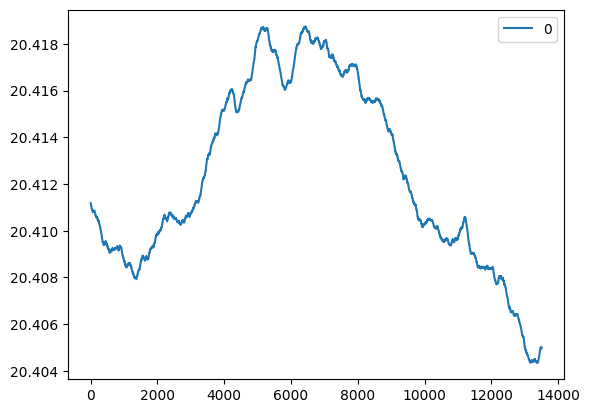

In [33]:
key, sub = jax.random.split(key)
xi = jft.random_like(sub, signal_response_tod.domain)
res = signal_response_tod(xi)
print(res.shape)

# for i in range(res.shape[0]):
# for i in range(0, n, n//10):
for i in [0]:
    plt.plot(np.arange(0, res.shape[1]), res[i], label=i)
plt.legend()
plt.show()

# MAP fit

In [ ]:
n_it = 1
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4

n_samples = 0 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60 # map
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=20 # map
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
)

OPTIMIZE_KL: Starting 0001


In [20]:
samples.pos

Vector(
	{'cfmapax1fluctuations': Array(8.64407006, dtype=float64),
	 'cfmapax1loglogavgslope': Array(-0.74623751, dtype=float64),
	 'cfmapxi': Array([[ -1.22532185,  -2.77221325,   5.44757735, ...,   0.57087265,
	         -5.19886969,   1.84303128],
	       [  6.61067048,  -5.22213003,  -0.68136767, ...,  -1.58612885,
	          8.48444739, -16.61577789],
	       [-10.1233893 ,   4.23189731,  -1.78144978, ...,  -2.11576707,
	         -3.46940454,   9.49527321],
	       ...,
	       [ -3.7737967 ,   2.61798188,   1.04693012, ...,   0.3889919 ,
	         -0.83812417,   2.80188312],
	       [ 12.14934149,  -9.15506373,   2.08848108, ...,  -0.08262998,
	          2.20807908,  -7.6027756 ],
	       [ -7.13296403,  16.45784485,  -7.22126557, ...,   0.903694  ,
	          0.77310086,   7.64846477]], dtype=float64),
	 'cfmapzeromode': Array(-0.46953549, dtype=float64),
	 'tod fluctuations': Array(0.98738311, dtype=float64),
	 'tod loglogavgslope': Array(2.06466097, dtype=float64),
	 'tod0 xi'

In [21]:
def printfitresults():
    print("Fit Results (res, init, std)")

    print("\nTODs:")
    print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_tod['fluctuations'])(samples.pos['tod fluctuations'])}, {cf_fl_tod['fluctuations'][0]}, {cf_fl_tod['fluctuations'][1]}")
    print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_tod['loglogavgslope'])(samples.pos['tod loglogavgslope'])}, {cf_fl_tod['loglogavgslope'][0]}, {cf_fl_tod['loglogavgslope'][1]}")
    print(f"\tzeromode std (LogNormal): {jft.LogNormalPrior(*cf_zm_tod['offset_std'])(samples.pos['zeromode'])}, {cf_zm_tod['offset_std'][0]}, {cf_zm_tod['offset_std'][1]}")

    # If custom zeromode per TOD:
    # for i in range(n):
    #     test = samples.pos[f"tod{i} zeromode"]
    #     print(f"tod{i} zeromode: {jft.LogNormalPrior(cf_zm_tod['offset_mean'], cf_zm_tod['offset_std'][0])(test)}, {cf_zm_tod['offset_mean']}, {cf_zm_tod['offset_std'][0]}")
    
    print("map:")
    print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_map['fluctuations'])(samples.pos['cfmapax1fluctuations'])}, {cf_fl_map['fluctuations'][0]}, {cf_fl_map['fluctuations'][1]}")
    print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_map['loglogavgslope'])(samples.pos['cfmapax1loglogavgslope'])}, {cf_fl_map['loglogavgslope'][0]}, {cf_fl_map['loglogavgslope'][1]}")
    print(f"\tzeromode std (LogNormal): {jft.LogNormalPrior(*cf_zm_map['offset_std'])(samples.pos['cfmapzeromode'])}, {cf_zm_map['offset_std'][0]}, {cf_zm_map['offset_std'][1]}")
    
    
printfitresults()

Fit Results (res, init, std)

TODs:
	fluctuations: 0.007412830596350061, 0.005, 0.003
	loglogvarslope: -1.9676695147578365, -3, 0.5
	zeromode std (LogNormal): 0.0026768059284058587, 0.0005, 0.001
map:
	fluctuations: 0.00047074682576933423, 3e-05, 1e-05
	loglogvarslope: -2.8731187535997513, -2.5, 0.5
	zeromode std (LogNormal): 3.6288462014389846e-10, 1e-08, 1e-07


(10018, 13500)


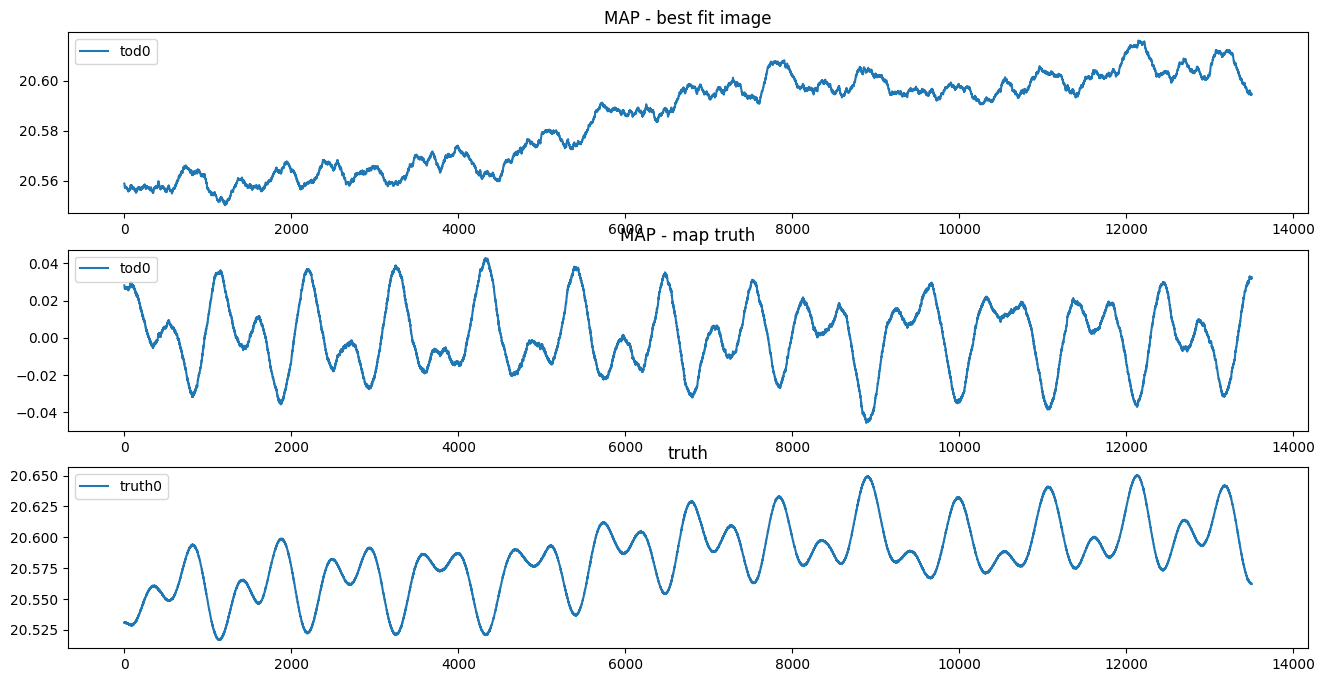

In [22]:
res = signal_response_tod(samples.pos)
print(res.shape)

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

# for i in range(0, res.shape[0], res.shape[0]//10):
# for i in range(0, n, n//10):
for i in [0]:
    im0 = axes[0].plot(np.arange(0, res.shape[1]), res[i], label=f"tod{i}")
    im1 = axes[1].plot(np.arange(0, res.shape[1]), res[i] - truth[i], label=f"tod{i}")
    im2 = axes[2].plot(truth[i], label=f"truth{i}")

axes[0].title.set_text('MAP - best fit image')
axes[0].legend()
axes[1].title.set_text('MAP - map truth')
axes[1].legend()
axes[2].title.set_text('truth')
axes[2].legend()

plt.show()

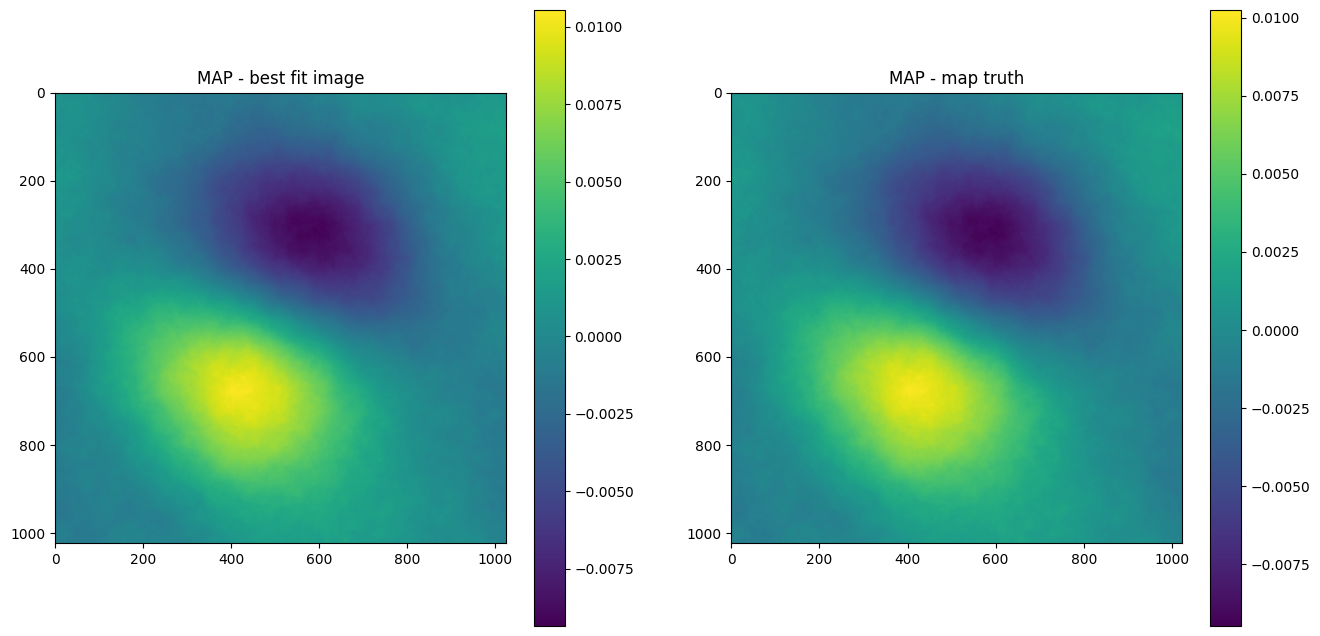

In [23]:
# plot maximum of posterior (mode)
sig_map = gp_map(samples.pos)[padding_map//2:-padding_map//2, padding_map//2:-padding_map//2] # when splitting up in different field models

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(sig_map)
axes[0].title.set_text('MAP - best fit image')
fig.colorbar(im0)

im1 = axes[1].imshow( sig_map - mapdata_truth[0] )
axes[1].title.set_text('MAP - map truth')
# im1 = axes[1].imshow( (sig_map - mapdata_truth) )
# axes[1].title.set_text('diff prediction - map truth')
fig.colorbar(im1)

plt.show()

In [24]:
# assert False

## Full nifty fit:

In [25]:
# n_it = 10
# n_it = 20
n_it = 50

if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4
n_samples = 4 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

# callback fn for plotting during optimisation:
def callback(samples, opt_state):
    mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

    fig_tods, axes_tods = plt.subplots(2, 1, figsize=(16, 6))

    # for i in range(0, mean.shape[0], mean.shape[0]//10):
    for i in range(0, n, n//10):
        axes_tods[0].plot(np.arange(0, mean.shape[1]), mean[i], label=f"tod{i}")
        axes_tods[0].plot(denoised_jax_tod[i], label=f"truth{i}")
        axes_tods[1].plot(np.arange(0, mean.shape[1]), mean[i] - denoised_jax_tod[i], label=f"tod{i}")

    axes_tods[0].title.set_text('mean prediction & truth (no noise)')
    axes_tods[0].legend()
    axes_tods[1].title.set_text('mean - truth (no noise)')
    axes_tods[1].legend()

    fig_map, axes_map = plt.subplots(1, 3, figsize=(16, 6))

    mean_map, _ = jft.mean_and_std(tuple(gp_map(s)[padding_map//2:-padding_map//2, padding_map//2:-padding_map//2] for s in samples))

    im0 = axes_map[0].imshow(mean_map)
    axes_map[0].title.set_text('mean map pred.')
    fig_map.colorbar(im0)

    im1 = axes_map[1].imshow(mean_map - mapdata_truth[0])
    axes_map[1].title.set_text('mean map - truth')
    fig_map.colorbar(im1)

    im2 = axes_map[2].imshow(mapdata_truth[0])
    axes_map[2].title.set_text('truth')
    fig_map.colorbar(im2)

    plt.show()
    

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
        # cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=10),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=10
        )
    ),
    # sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
    sample_mode = lambda x: "nonlinear_resample" if x >= 1 else "linear_resample",
    callback=callback,
)

OPTIMIZE_KL: Starting 0001


In [26]:
printfitresults()

Fit Results (res, init, std)

TODs:
	fluctuations: 0.03553279656804626, 0.005, 0.003
	loglogvarslope: -3.34995154213354, -3, 0.5
	zeromode std (LogNormal): 0.00033200276444834043, 0.0005, 0.001
map:
	fluctuations: 1.0348342917058488e-05, 3e-05, 1e-05
	loglogvarslope: -2.4617297004643226, -2.5, 0.5
	zeromode std (LogNormal): 2.41682978745645e-10, 1e-08, 1e-07


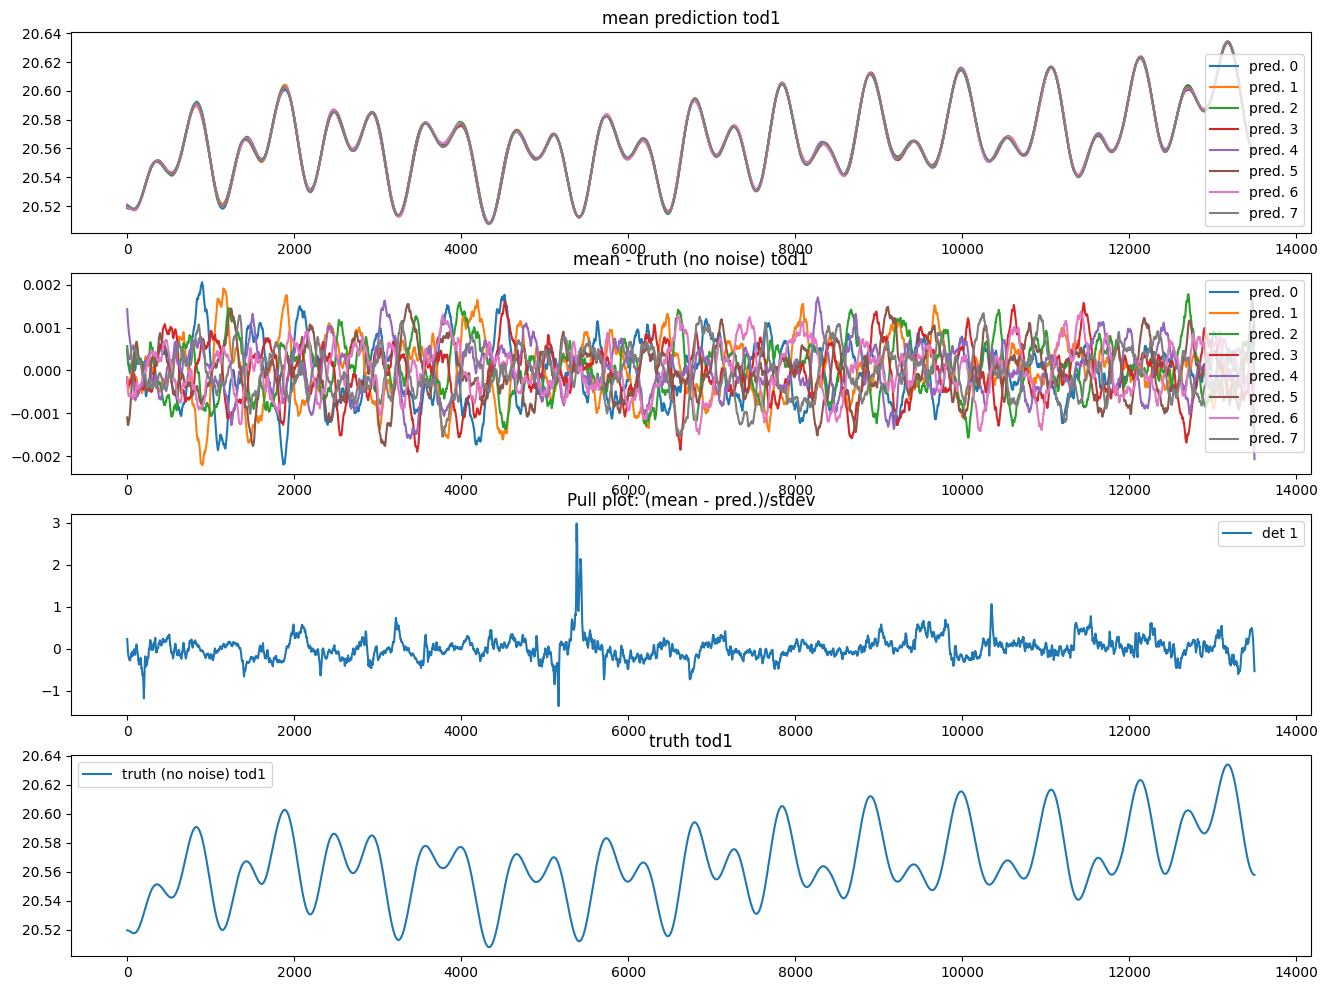

In [27]:
mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

fig, axes = plt.subplots(4, 1, figsize=(16, 12))
i = 1 # TOD id
j = 0
# for i in range(mean.shape[0]):
for s in samples:
    pred = signal_response_tod(s)
    
    im0 = axes[0].plot(np.arange(0, pred.shape[1]), pred[i], label=f"pred. {j}")
    im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i], label=f"pred. {j}")
    j += 1

im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i])/std[i], label=f"det {i}")
im3 = axes[3].plot(denoised_jax_tod[i], label=f"truth (no noise) tod{i}")
axes[0].title.set_text(f"mean prediction tod{i}")
axes[0].legend()
axes[1].title.set_text(f"mean - truth (no noise) tod{i}")
axes[1].legend()
axes[2].title.set_text(f"Pull plot: (mean - pred.)/stdev")
axes[2].legend()
axes[3].title.set_text(f"truth tod{i}")
axes[3].legend()

plt.show()

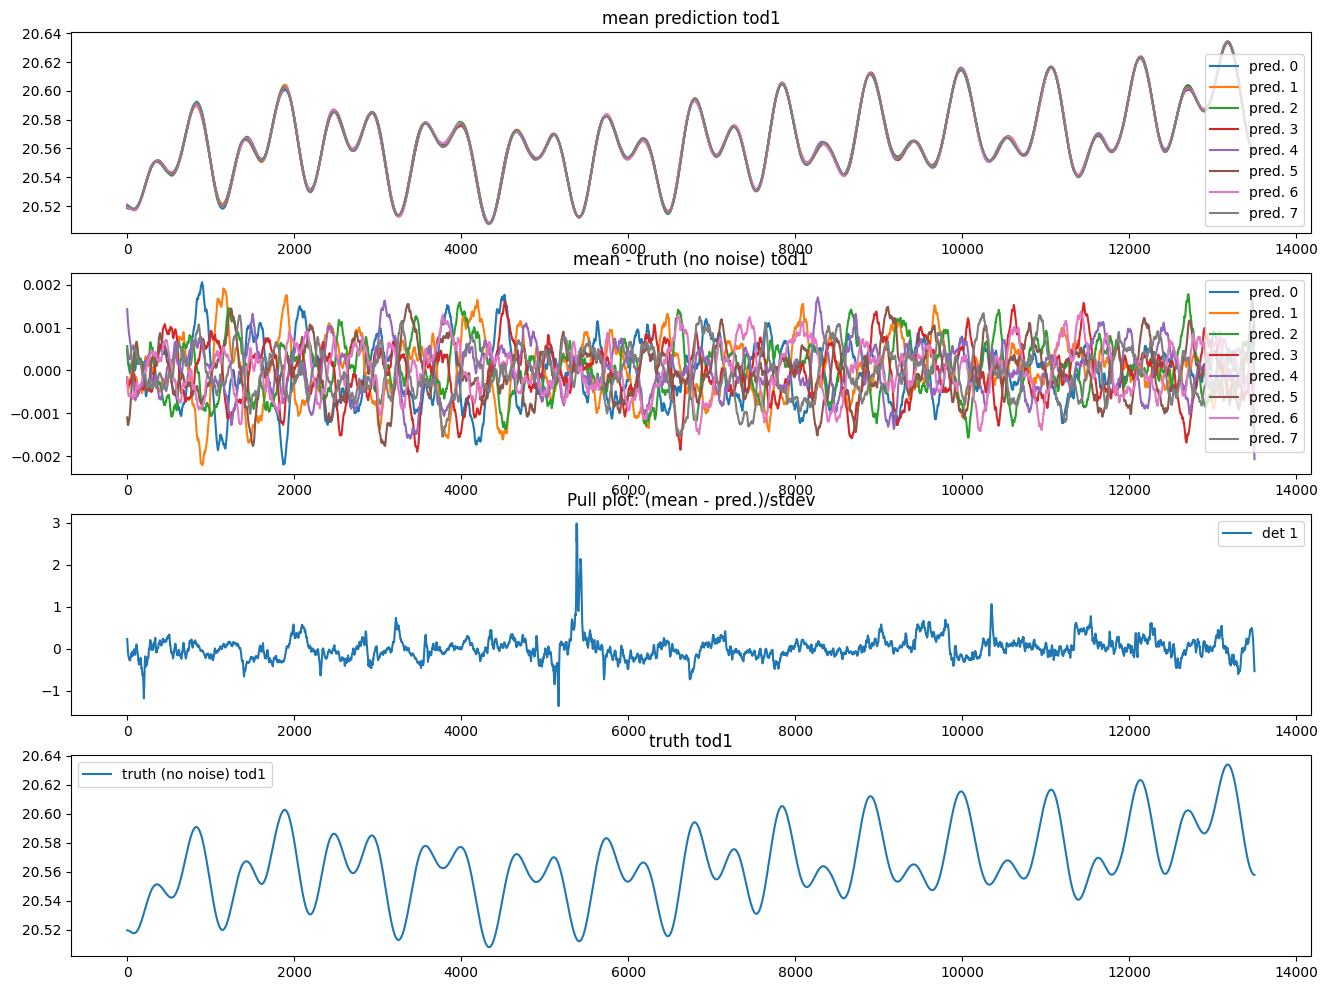

In [28]:
fig, axes = plt.subplots(4, 1, figsize=(16, 12))
i = 1 # TOD id
j = 0
# for i in range(mean.shape[0]):
for s in samples:
    pred = signal_response_tod(s)
    
    im0 = axes[0].plot(np.arange(0, pred.shape[1]), pred[i], label=f"pred. {j}")
    im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i], label=f"pred. {j}")
    j += 1

im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i])/std[i], label=f"det {i}")
im3 = axes[3].plot(denoised_jax_tod[i], label=f"truth (no noise) tod{i}")
axes[0].title.set_text(f"mean prediction tod{i}")
axes[0].legend()
axes[1].title.set_text(f"mean - truth (no noise) tod{i}")
axes[1].legend()
axes[2].title.set_text(f"Pull plot: (mean - pred.)/stdev")
axes[2].legend()
axes[3].title.set_text(f"truth tod{i}")
axes[3].legend()

plt.show()

## Compare with maria mapper:

In [29]:
# Compare with maria mapper:
from maria.map.mappers import BinMapper

mapper = BinMapper(center=(300.0, -10.0),
                   frame="ra_dec",
                   width=1.,
                   height=1.,
                   resolution=np.degrees(np.nanmin(instrument.fwhm))/4.,
                   tod_postprocessing={
                        "window": {"tukey": {"alpha": 0.1}},
                        "remove_modes": {"n": 1},
                        "highpass": {"f": 0.05},
                        "despline": {"spacing": 10},
                    },
                    map_postprocessing={
                        "gaussian_filter": {"sigma": 1},
                        "median_filter": {"size": 1},
                    },
                  )


mapper.add_tods(tod_truthmap)
output_map = mapper.run()

Running mapper (f092): 100%|██████████| 1/1 [01:53<00:00, 113.33s/it]


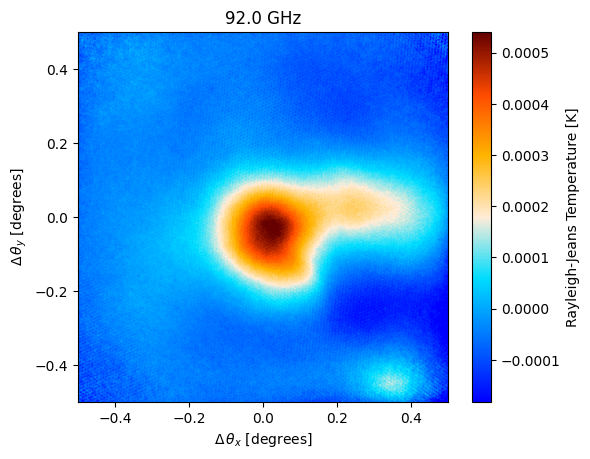

In [30]:
output_map.plot()

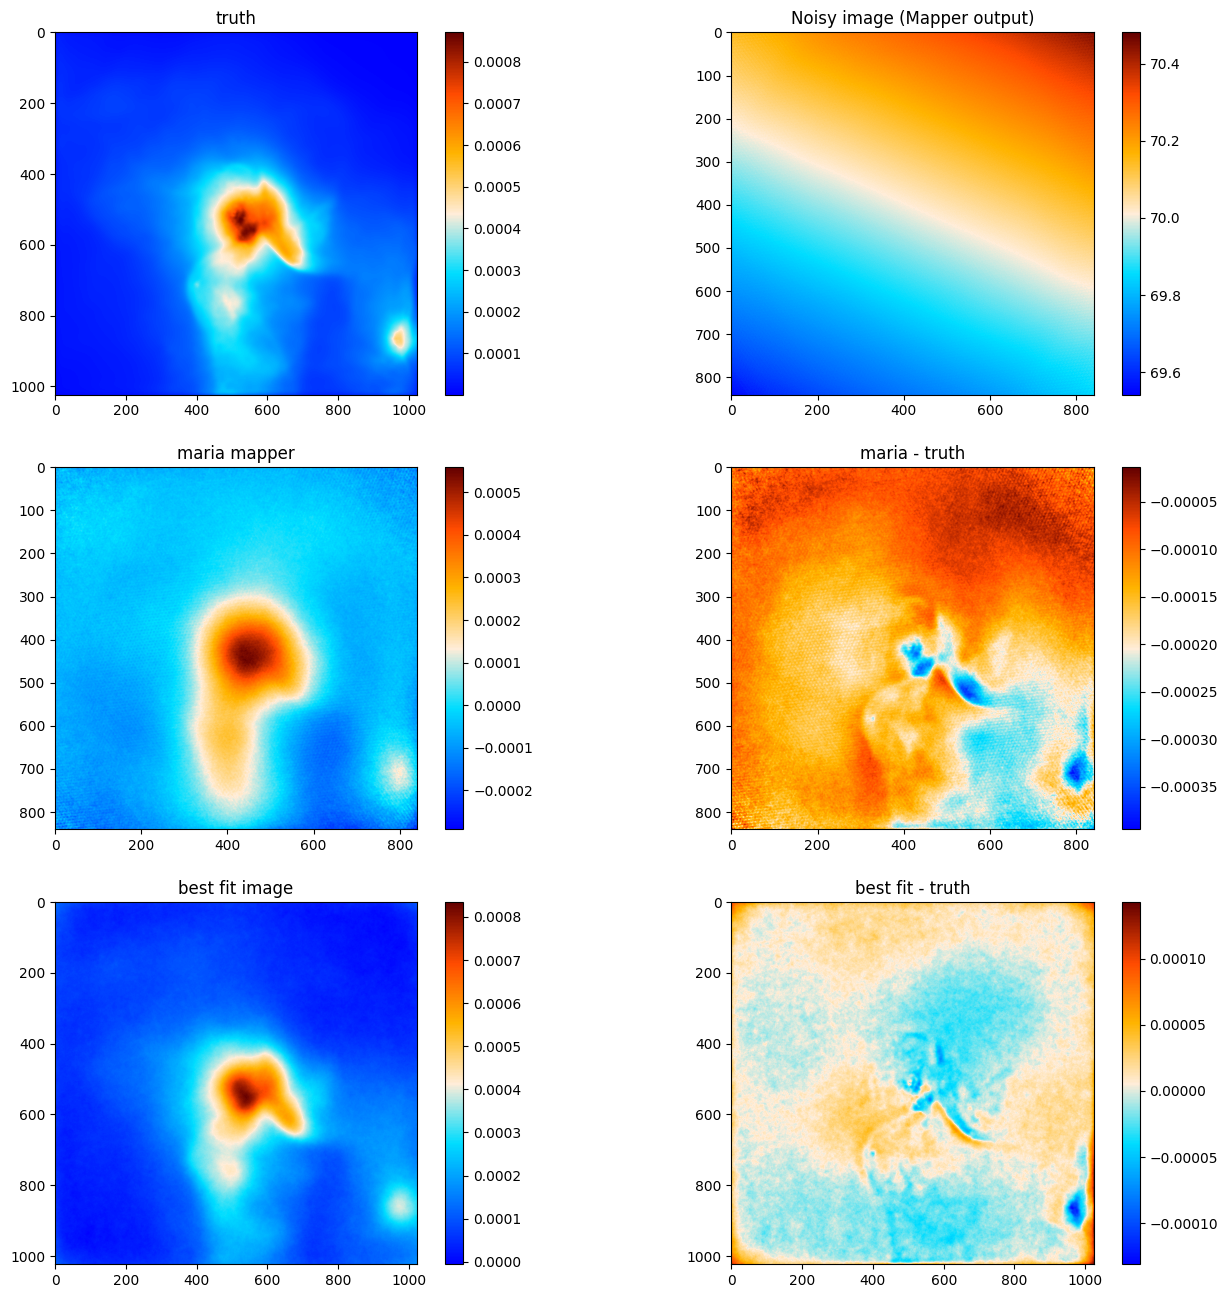

In [31]:
from skimage.transform import resize

# Compare nifty vs maria
sig_map = gp_map(samples.pos)[padding_map//2:-padding_map//2, padding_map//2:-padding_map//2] # when splitting up in different field models
# mincol = -0.0012
# maxcol = 0.
mincol = None
maxcol = None

cmb_cmap = plt.get_cmap('cmb')
fig, axes = plt.subplots(3, 2, figsize=(16, 16))

im0 = axes[0,0].imshow( mapdata_truth[0] , cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[0,0].title.set_text('truth')
fig.colorbar(im0)

im1 = axes[0,1].imshow(output_truthmap.data[0], cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
fig.colorbar(im1)
axes[0,1].title.set_text("Noisy image (Mapper output)")

im2 = axes[1,0].imshow( output_map.data[0], cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[1,0].title.set_text('maria mapper')
fig.colorbar(im2)

truth_rescaled = resize(mapdata_truth[0], (841,841), anti_aliasing=True)
im3 = axes[1,1].imshow(( output_map.data[0] - truth_rescaled), cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[1,1].title.set_text('maria - truth')
fig.colorbar(im3)

im3 = axes[2,0].imshow(sig_map, cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[2,0].title.set_text('best fit image')
fig.colorbar(im3)

im4 = axes[2,1].imshow((sig_map - mapdata_truth[0]), cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[2,1].title.set_text('best fit - truth')
fig.colorbar(im4)

plt.show()